# Negative Sample Generation from Blank Areas in Australia

This notebook outlines the process of generating negative training samples for mineral prospectivity mapping by identifying and sampling blank areas across Australia — regions with no known mineral deposits within a 50 km buffer zone of any positive sample or other known mineral site.

## 1.Objective

To obtain geospatially distributed, high-quality negative samples for training machine learning models by:
- Excluding areas around known deposits (positive and other mineral sites)
- Ensuring sampled points fall within blank, underexplored, or mineral-absent geological provinces
- Stratifying samples based on the area of each geological province to achieve spatial diversity

## 2.Positive and Other Mineral Sites Buffering

A 50 km buffer is created around both porphyry copper deposits and all other mineral occurrences to eliminate zones with known mineralization.

In [45]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
from shapely.geometry import Point

# Load all countries
world = gpd.read_file("../../data/raw/Dataset/australia_boundary/ne_110m_admin_0_countries.shp")

# Extract Australia only
aus_land = world[world["NAME"] == "Australia"].to_crs("EPSG:3577")

# Read the positive samples
positive_df = pd.read_csv('../data/processed/positive_augmented_patch.csv')
positive_gdf = gpd.GeoDataFrame(
    positive_df,
    geometry=[Point(xy) for xy in zip(positive_df['LONGITUDE'], positive_df['LATITUDE'])],
    crs="EPSG:4326"
)

# Read the negative samples (from other deposits)
negative_df = pd.read_csv('../../data/processed/negative_other_deposit_samples.csv')
negative_gdf = gpd.GeoDataFrame(
    negative_df,
    geometry=[Point(xy) for xy in zip(negative_df['LONGITUDE'], negative_df['LATITUDE'])],
    crs="EPSG:4326"
)

# projection conversion
positive_proj = positive_gdf.to_crs("EPSG:3577")
negative_proj = negative_gdf.to_crs("EPSG:3577")

# Create buffer 50 km
positive_buffer = positive_proj.geometry.buffer(50000)
negative_buffer = negative_proj.geometry.buffer(50000)

# union all buffer areas
all_buffers = pd.concat([
    gpd.GeoDataFrame(geometry=positive_buffer),
    gpd.GeoDataFrame(geometry=negative_buffer)
])
merged_buffers = unary_union(all_buffers.geometry)

# obtain blank area from AUS boundary - merged buffers
aus_boundary_proj = aus_land.to_crs("EPSG:3577")
blank_area_geom = aus_boundary_proj.geometry.iloc[0].difference(merged_buffers)
blank_gdf = gpd.GeoDataFrame(geometry=[blank_area_geom], crs="EPSG:3577")

The combined buffer zones are subtracted from the landmass of mainland Australia to define regions considered "blank" for sampling.

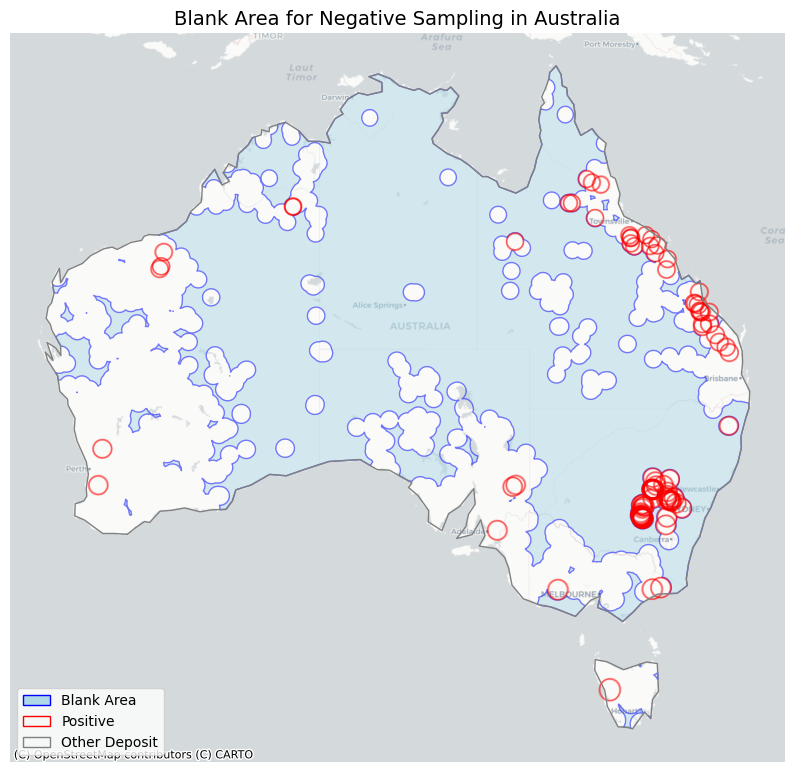

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx


# Reproject all GeoDataFrames to EPSG:3857 for basemap alignment
gdf_boundary_web = aus_land.to_crs(epsg=3857)
gdf_buffer_web = positive_buffer.to_crs(epsg=3857)
gdf_blank_web = blank_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 12))

gdf_blank_web.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
gdf_buffer_web.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.1)
gdf_boundary_web.plot(ax=ax, facecolor='none', edgecolor='gray')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Patch(facecolor='lightblue', edgecolor='blue', label='Blank Area'),
    Patch(facecolor='none', edgecolor='red', label='Positive'),
    Patch(facecolor='none', edgecolor='gray', label='Other Deposit')
]
ax.legend(handles=legend_elements, loc='lower left')

ax.set_title("Blank Area for Negative Sampling in Australia", fontsize=14)
ax.axis("off")
plt.show()


## 3.Geological Province 

The blank areas are spatially intersected with geological province boundaries to allow stratified sampling by province.

In [47]:
# Read Geological Provinces
province_gdf = gpd.read_file("../../data/raw/Dataset/GA/Geological Provinces/ProvinceFullExtent.shp").to_crs("EPSG:3577")

In [48]:
# only keep onshore area
province_gdf = province_gdf[province_gdf["ONOFFSHORE"].str.lower() == "on"]
blank_by_province = gpd.overlay(blank_gdf, province_gdf[["PROVINCEID", "NAME", "TYPE", "geometry"]], how="intersection")


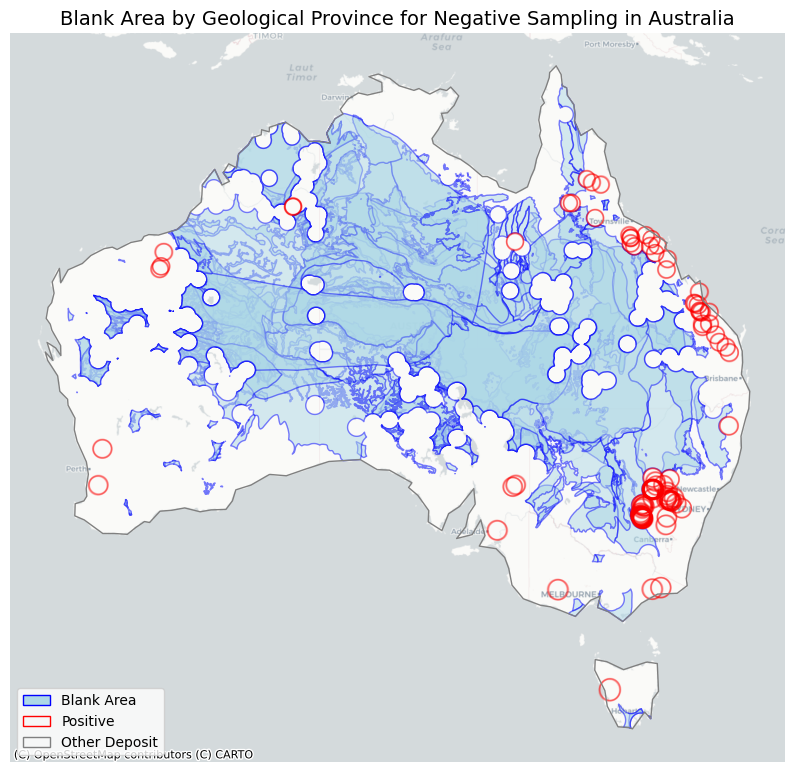

In [49]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx

# Reproject all GeoDataFrames to EPSG:3857 for basemap alignment
gdf_boundary_web = aus_land.to_crs(epsg=3857)
gdf_buffer_web = positive_buffer.to_crs(epsg=3857)
gdf_blank_web = blank_by_province.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 12))

gdf_blank_web.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
gdf_buffer_web.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.1)
gdf_boundary_web.plot(ax=ax, facecolor='none', edgecolor='gray')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Patch(facecolor='lightblue', edgecolor='blue', label='Blank Area'),
    Patch(facecolor='none', edgecolor='red', label='Positive'),
    Patch(facecolor='none', edgecolor='gray', label='Other Deposit')
]
ax.legend(handles=legend_elements, loc='lower left')

ax.set_title("Blank Area by Geological Province for Negative Sampling in Australia", fontsize=14)
ax.axis("off")
plt.show()

## 4.Area-Proportional Stratified Sampling
The number of samples per province is determined proportionally to its blank area size, ensuring a fair and realistic distribution of negative samples.

In [50]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

def sample_points_in_polygon(polygon, n_samples, seed=42, max_attempts=10000):
    """
    Sample n_samples points uniformly within the given polygon.
    """
    np.random.seed(seed)
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    attempts = 0

    while len(points) < n_samples and attempts < max_attempts:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            points.append(p)
        attempts += 1

    if len(points) < n_samples:
        print(f"⚠️ Only sampled {len(points)} points after {attempts} attempts in polygon.")

    return points


In [51]:
# Make sure CRS is EPSG:3577
blank_by_province_proj = blank_by_province.to_crs(epsg=3577)

# Clculate area in square meters
blank_by_province_proj["area_m2"] = blank_by_province_proj.geometry.area

# GROUP Sum by PROVINCEID
province_area_df = blank_by_province_proj.groupby("PROVINCEID")["area_m2"].sum().reset_index()

# Set target number of samples
TARGET_TOTAL = 4000

# Calculate ratio
province_area_df["ratio"] = province_area_df["area_m2"] / province_area_df["area_m2"].sum()
province_area_df["n_samples"] = (province_area_df["ratio"] * TARGET_TOTAL).round().astype(int)


In [52]:
# distribute samples to blank_by_province
blank_with_samples = blank_by_province.merge(province_area_df[["PROVINCEID", "n_samples"]], on="PROVINCEID")

In [53]:
# sampling by area

def stratified_sample_by_area(blank_with_samples, group_col="PROVINCEID", seed=42):
    np.random.seed(seed)
    all_samples = []

    for pid, group in blank_with_samples.groupby(group_col):
        n_samples = group["n_samples"].iloc[0]
        polygon = group.geometry.union_all()
        points = sample_points_in_polygon(polygon, n_samples, max_attempts=50000)

        gdf_points = gpd.GeoDataFrame(
            {group_col: [pid] * len(points)},
            geometry=points,
            crs=blank_with_samples.crs
        )
        all_samples.append(gdf_points)
    
    sampled_gdf = pd.concat(all_samples, ignore_index=True)
    sampled_gdf["LABEL"] = 0
    return sampled_gdf


In [54]:
sampled_negatives = stratified_sample_by_area(
    blank_with_samples, group_col="PROVINCEID", seed=42
)

In [55]:
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_stratified_sampling_result(
    blank_by_province,
    sampled_points_gdf,
    group_col="PROVINCEID",
    figsize=(12, 14),
    basemap=False
):
    """
    visualize stratified sampling result
    - blank_by_province: original blank area（include polygon）
    - sampled_points_gdf: sample points（include group_col and geometry）
    """
    fig, ax = plt.subplots(figsize=figsize)

    blank_by_province.boundary.plot(ax=ax, linewidth=0.5, color="lightgray")

    sampled_points_gdf.plot(ax=ax, column=group_col, markersize=5, cmap="tab20", legend=False)

    if basemap:
        import contextily as ctx
        sampled_web = sampled_points_gdf.to_crs(epsg=3857)
        blank_web = blank_by_province.to_crs(epsg=3857)
        ax.clear()
        blank_web.boundary.plot(ax=ax, linewidth=0.5, color="lightgray")
        sampled_web.plot(ax=ax, column=group_col, markersize=5, cmap="tab20", legend=False)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.set_title("Stratified Sampling in Geological Provinces (Negative Samples)", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


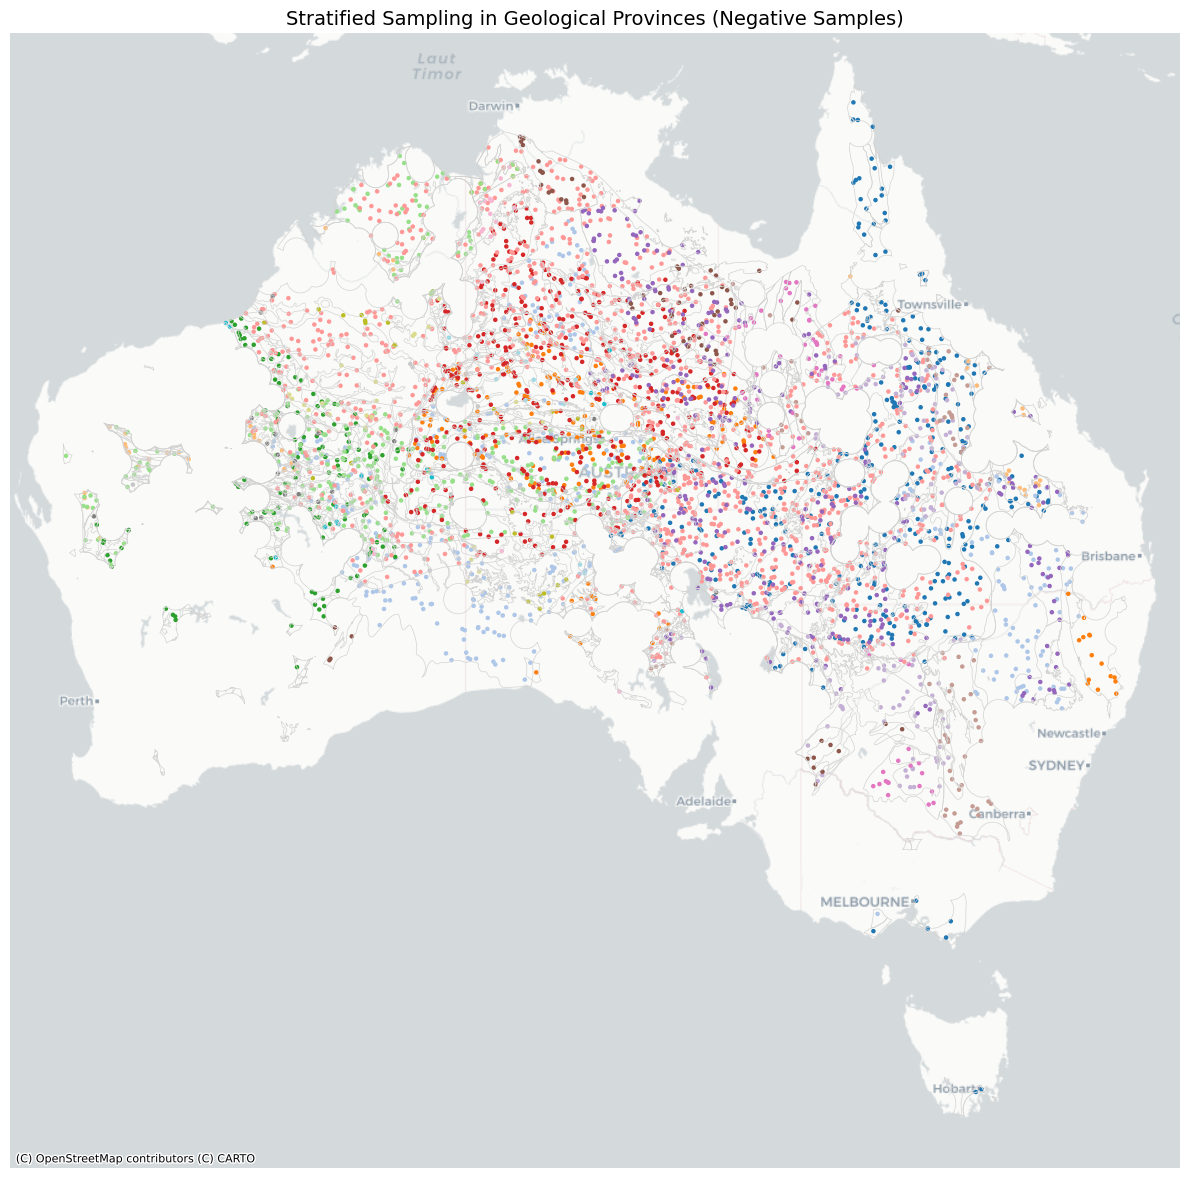

In [56]:
plot_stratified_sampling_result(
    blank_by_province=blank_by_province,
    sampled_points_gdf=sampled_negatives,
    group_col="PROVINCEID",
    basemap=True
)


## 5.Sampling and Export
Sampled points are converted to longitude/latitude coordinates and exported to a CSV file for downstream analysis and model training.

In [57]:
# convert CRS to WGS
negative_samples_wgs = sampled_negatives.to_crs("EPSG:4326")

# extract longitude and latitude
negative_samples_wgs["LONGITUDE"] = negative_samples_wgs.geometry.x
negative_samples_wgs["LATITUDE"] = negative_samples_wgs.geometry.y

# filter fileds
cols_to_save = ["PROVINCEID", "LONGITUDE", "LATITUDE", "LABEL"]
negative_samples_wgs[cols_to_save].to_csv("../../data/processed/negative_blank_samples.csv", index=False)

print("✅ negative_blank_samples.csv saved successfully.")


✅ negative_blank_samples.csv saved successfully.
